# Octane applicability domain

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from rdkit import Chem

'''custom modules'''
from filter_data import Select_descriptors
from process_data import Scalar
from simmilarity import mean_tanimato,Leverage,Partition
from train import Model

In [2]:
df = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\octane_data.csv')

In [3]:
df.head(5)

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,...,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,Complexity,XLogP,boiling_point_K
0,CCCCO,1-Butanol,98.00,263,"Sandia, UML",[6],N-BUTANOL,98.0,Validation,92.76,...,14,12,2.750000,1.500000,0.000000,98.00,abs dev < 0.01,13,0.9,390.81
1,CCO,Ethanol,109.00,702,"Sandia, UML",[6],ETHANOL,109.0,Training,107.77,...,6,4,2.250000,1.000000,0.000000,109.00,abs dev < 0.01,2,-0.1,351.44
2,CO,Methanol,109.00,887,"Sandia, UML",[11],METHANOL,122.0,Training,105.38,...,2,1,2.000000,1.000000,0.059633,109.00,WIKIPEDIA 108.7,2,-0.5,337.85
3,CCCO,n-Propanol,104.00,1031,"Sandia, UML",[6],N-PROPANOL,104.0,Training,100.25,...,10,8,2.500000,1.250000,0.000000,104.00,abs dev < 0.01,7,0.3,370.35
4,CC1=CC=CC=C1,Toluene,118.17,1140,"Sandia, UML","[1], [3]",NaN,NaN,NaN,NaN,...,30,31,2.361111,1.666667,NaN,118.17,no alternative,42,2.7,384.62


### 1. Data preprocessing

In [4]:
### 1.1 Remove columns with missing values
misssing_val_cols = df.columns[df.isnull().any()]
print('Columns with missing values are = {}'.format(list(misssing_val_cols)))

Columns with missing values are = ['Compound Name', 'TARGET', 'Source', 'Literature Source', 'RON_Molecules_x', 'Experiment', 'Data Set', 'Predicted', 'Absolute  Error', '#Name', 'RON', 'dev', 'boiling_point_K']


In [5]:
### 1.2 Remove columns with irrelevant to modelling values
df_ = df.drop(misssing_val_cols,axis=1)

irrelevant_to_pred_columns = ['PubChem','ron_choice']

df_ = df_.drop(irrelevant_to_pred_columns,axis=1)

In [6]:
print('final dataset sie = {}'.format(df_.shape))

final dataset sie = (492, 879)


### 2. Split dataset (standartization must be applied on train set only )

In [7]:
seed = 42 # Fix random seed to make split reproducible (experiment must be reproducible)

X_train, X_test, y_train, y_test = train_test_split(df_.drop('y',axis=1), df_['y'], test_size=0.2, random_state=seed)

In [8]:
print('Train dataset size = {}'.format(X_train.shape))
print('Test dataset size = {}'.format(X_test.shape))

Train dataset size = (393, 878)
Test dataset size = (99, 878)


In [51]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

In [9]:
# Normilise features, so varince threshold can be applied
sc         = Scalar('minmax')

# Wrapper feature selector
wrapper    = sfs(SVR(gamma='auto'),
              n_features_to_select=50,
              scoring='neg_mean_squared_error',
              cv=5)

#wrapper    = SelectFromModel(RandomForestRegressor(n_estimators=300),max_features=50)
# Applies varience threshold, removes high correlated features, removes higly skewed vars and applies wrapper in the end.

'''
wrapper    = sfs(RandomForestRegressor(n_estimators=300),n_features_to_select=50,
                 scoring='neg_mean_squared_error',
                 cv=5)
'''
Filter_    = Select_descriptors(0.01,0.95,None,None)

sc.fit(X_train)

In [10]:
X_train  = Filter_.transform(sc.transform(X_train),y_train)

In [11]:
X_train.head(5)

,SMILES,ABC,SpAbs_A,SpMax_A,SpDiam_A,SpMAD_A,VE2_A,nAromAtom,nAtom,nBridgehead,...,JGI7,JGT10,Diameter,Radius,TopoShapeIndex,SRW05,TSRW10,mZagreb1,Complexity,XLogP
0,Cc1c(C)cccc1C,0.742801,0.741973,0.771745,0.813027,0.704412,0.126501,1.0,0.517241,0.0,...,0.0,0.578490,0.375,0.50,0.333333,0.000000,0.549716,0.527132,0.358491,0.640625
1,CC1CCCC(C1)C,0.660152,0.620122,0.717707,0.756099,0.650734,0.183360,0.0,0.620690,0.0,...,0.0,0.537208,0.375,0.50,0.333333,0.000000,0.509673,0.366925,0.273585,0.671875
2,CC(c1ccccc1)(C)C,0.841107,0.816854,0.786660,0.828740,0.650686,0.079701,1.0,0.620690,0.0,...,0.0,0.646033,0.500,0.50,0.666667,0.000000,0.580511,0.590439,0.429245,0.718750
3,CC(CC1CCCCC1)C,0.819045,0.840067,0.717707,0.756099,0.698460,0.085722,0.0,0.827586,0.0,...,0.0,0.457626,0.625,0.50,1.000000,0.000000,0.559529,0.459948,0.367925,0.828125
4,CC1CCC(O1)C,0.580705,0.527266,0.731974,0.678987,0.666967,0.232863,0.0,0.448276,0.0,...,0.0,0.583679,0.375,0.25,1.000000,0.545665,0.719360,0.320413,0.250000,0.265625


In [12]:
ml_model = Model('SVM',X_train,y_train,150)

model_   = ml_model.build_model()

[I 2022-05-23 07:32:49,189] A new study created in memory with name: no-name-8aea8766-cedd-4465-b5d5-3f987daed65f
[I 2022-05-23 07:32:49,626] Trial 0 finished with value: -14.852211322631451 and parameters: {'C': 0.16997142400663776, 'gamma': 0.007084810153133516, 'degree': 3}. Best is trial 0 with value: -14.852211322631451.
[I 2022-05-23 07:32:50,175] Trial 1 finished with value: -15.206392114297895 and parameters: {'C': 0.017713875427593798, 'gamma': 0.00166090428545029, 'degree': 8}. Best is trial 0 with value: -14.852211322631451.
[I 2022-05-23 07:32:50,493] Trial 2 finished with value: -15.212841467643917 and parameters: {'C': 0.009092224327240644, 'gamma': 0.0010104346848209729, 'degree': 8}. Best is trial 0 with value: -14.852211322631451.
[I 2022-05-23 07:32:50,839] Trial 3 finished with value: -13.804801979349026 and parameters: {'C': 1.2478177711637266, 'gamma': 0.004384894643355927, 'degree': 2}. Best is trial 3 with value: -13.804801979349026.
[I 2022-05-23 07:32:51,174] T

### Performance on the test set

In [13]:
# Calculate prediction errors
y_pred_test = model_.predict(sc.transform(X_test)[X_train.columns[1:]])
mae         = np.abs(y_test.values-y_pred_test)

Text(0, 0.5, 'expected')

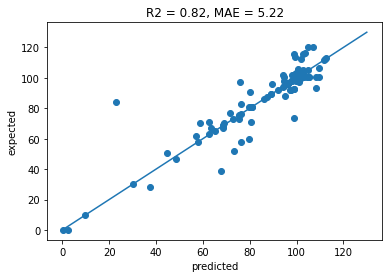

In [14]:
plt.scatter(y_pred_test,y_test)
plt.plot(np.linspace(0,130,10),np.linspace(0,130,10))
plt.title('R2 = {}, MAE = {}'.format(round(r2_score(y_pred_test,y_test),2),round(mean_absolute_error(y_pred_test,y_test),2)))
plt.xlabel('predicted')
plt.ylabel('expected')

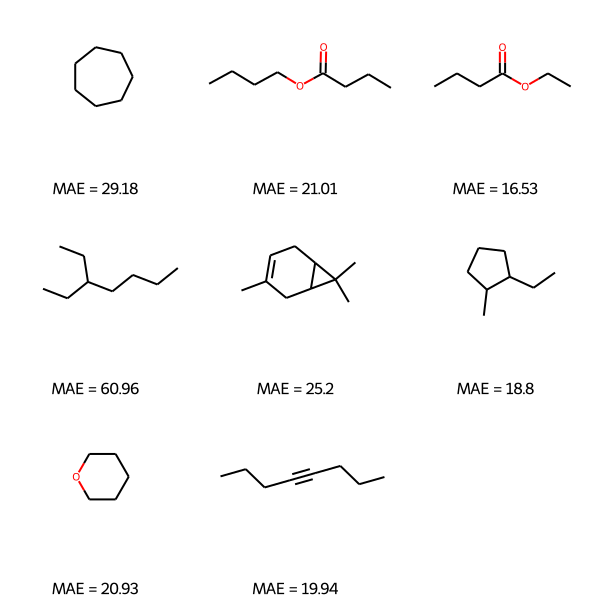

In [15]:
## Display compounds with the worst predictions
abs_error_threshold = 15

data_error = pd.DataFrame(columns=['SMILES','MAE'])
data_error['SMILES'] = X_test.iloc[np.where(mae>abs_error_threshold)[0]]['SMILES'].values
data_error['MAE'] = mae[np.where(mae>abs_error_threshold)[0]]
worst_mols = [Chem.MolFromSmiles(x) for x in data_error['SMILES'].astype('str').values]
Chem.Draw.MolsToGridImage(worst_mols,legends=['MAE'+' '+'='+' '+ str(round(x,2)) for x in list(data_error['MAE'].values)])

### Applicability domain

In [16]:
def means(x):
    vals = []
    for key, value in x.items():
        if value['error'] is not None:
            vals.append(value['error'].mean())
    return vals


def plot_boxplot(errors):

    fig, ax = plt.subplots(figsize=(10,7))



    means_ = np.array([errors[x]['error'] for x in [0.01,0.2,0.4,0.6,0.8]])
    fractions = [round(len(errors[x]['error'])/len(X_test),2) for x in [0.01,0.2,0.4,0.6,0.8]]

    range_x  = np.arange(1,len(means_)+1)
    range_y  = [np.mean(x) for x in means_]

    ax.scatter(range_x, range_y, color='r')
    for i, txt in enumerate(fractions):
        ax.annotate(txt, (range_x[i]+0.27, range_y[i]-0.25))
    ax.boxplot(means_,labels=[0.01,0.2,0.4,0.6,0.8])
    ax.set_xlabel('% Outliers ')
    ax.set_ylabel('MAE')

1. OneClassSVM

In [19]:
range  =  sorted(list(np.linspace(0.001,0.96,20)) + [0.01,0.2,0.4,0.6,0.8])
P      =  Partition(X_train,sc.transform(X_test),mae,'OneClassSVM',range,gamma=0.2,kernel="rbf")
errors =  P.calculate()

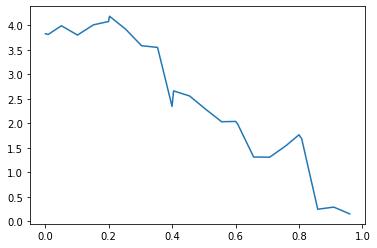

In [20]:
plt.plot(range,means(errors))

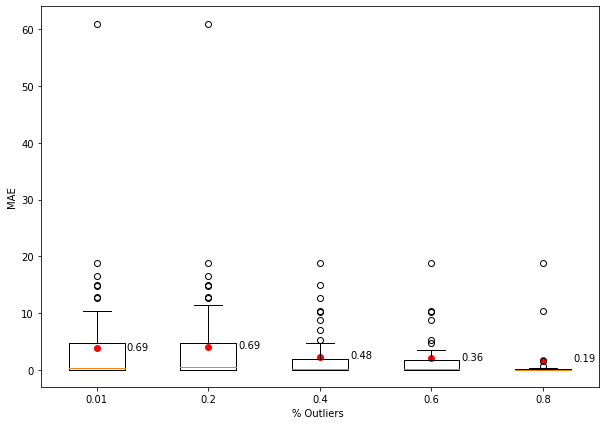

In [21]:
plot_boxplot(errors)

2.Tanimato distance

In [22]:
range_  = sorted(list(np.linspace(0.1,0.96,20))+[0.01,0.2,0.4,0.6,0.8])
P      = Partition(X_train,sc.transform(X_test),mae,'Tanimoto',range_)
errors = P.calculate()

In [23]:
new_range   = []
means_pred  = []
for i,item in enumerate(range_):
    x = errors[item]['error']
    if len(x)!= 0:
        new_range.append(item)
        means_pred.append(np.mean(x))

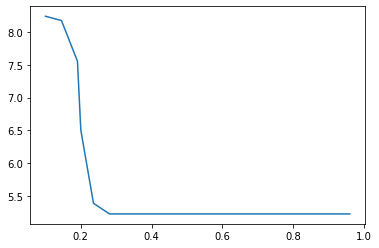

In [24]:
plt.plot(new_range,means_pred)

Text(0, 0.5, 'MAE')

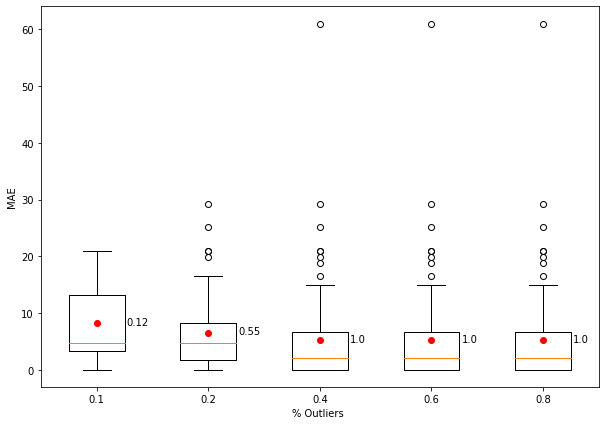

In [29]:
fig, ax = plt.subplots(figsize=(10,7))

range2 = [new_range[0]]+[0.2,0.4,0.6,0.8]

means_ = np.array([errors[x]['error'] for x in range2])
fractions = [round(len(errors[x]['error'])/len(X_test),2) for x in range2]

range_x  = np.arange(1,len(means_)+1)
range_y  = [np.mean(x) for x in means_]

ax.scatter(range_x, range_y, color='r')
for i, txt in enumerate(fractions):
    ax.annotate(txt, (range_x[i]+0.27, range_y[i]-0.25))
ax.boxplot(means_,labels=range2)
ax.set_xlabel('% Outliers ')
ax.set_ylabel('MAE')

3. Leaverage distance

In [30]:
P      = Partition(X_train,sc.transform(X_test),mae,'leverage',np.linspace(0.25,0.96,20))
P.check_inverse()

False

In [32]:
## Can't find leaverage distance for full set of descriptors, since (X^T X) matrix is not invertible

4. Isolation forest

In [35]:
range  =  sorted(list(np.linspace(0.001,0.96,20)) + [0.01,0.2,0.4,0.6,0.8])
P      = Partition(X_train,sc.transform(X_test),mae,'IsolationForest',range,n_estimators=400)
errors = P.calculate()

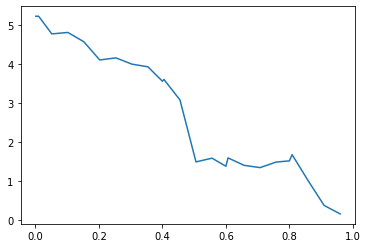

In [37]:
plt.plot(range,means(errors))

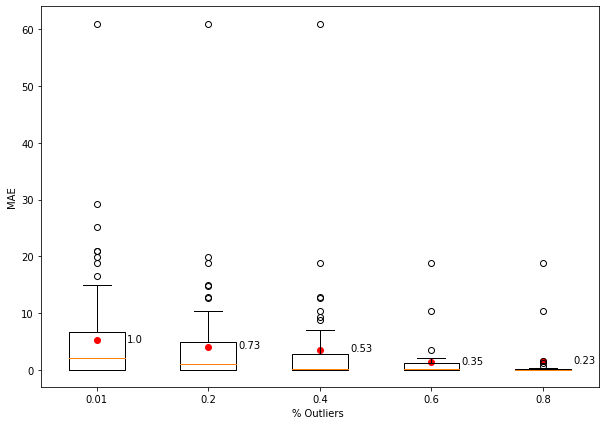

In [38]:
plot_boxplot(errors)